# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
## This code will download the train/test zip file and extract it in the current directory 
import os.path
has_train_data = os.path.isfile('train.p') 
if not has_train_data:
    from zipfile import ZipFile
    import urllib.request
    from tempfile import mktemp

    zipurl = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip'
    from urllib.request import urlopen
    from zipfile import ZipFile
    zipresp = urlopen(zipurl)
    tempzip = open("/tmp/tempfile.zip", "wb")
    tempzip.write(zipresp.read())
    tempzip.close()
    zf = ZipFile("/tmp/tempfile.zip")
    zf.extractall()
    zf.close()

In [2]:
## extract the training and testing data
import pickle
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
del train, test # Free up memory

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##Imort label names
df = pd.read_csv('signnames.csv')
sign_names = df.set_index('ClassId').to_dict()['SignName']

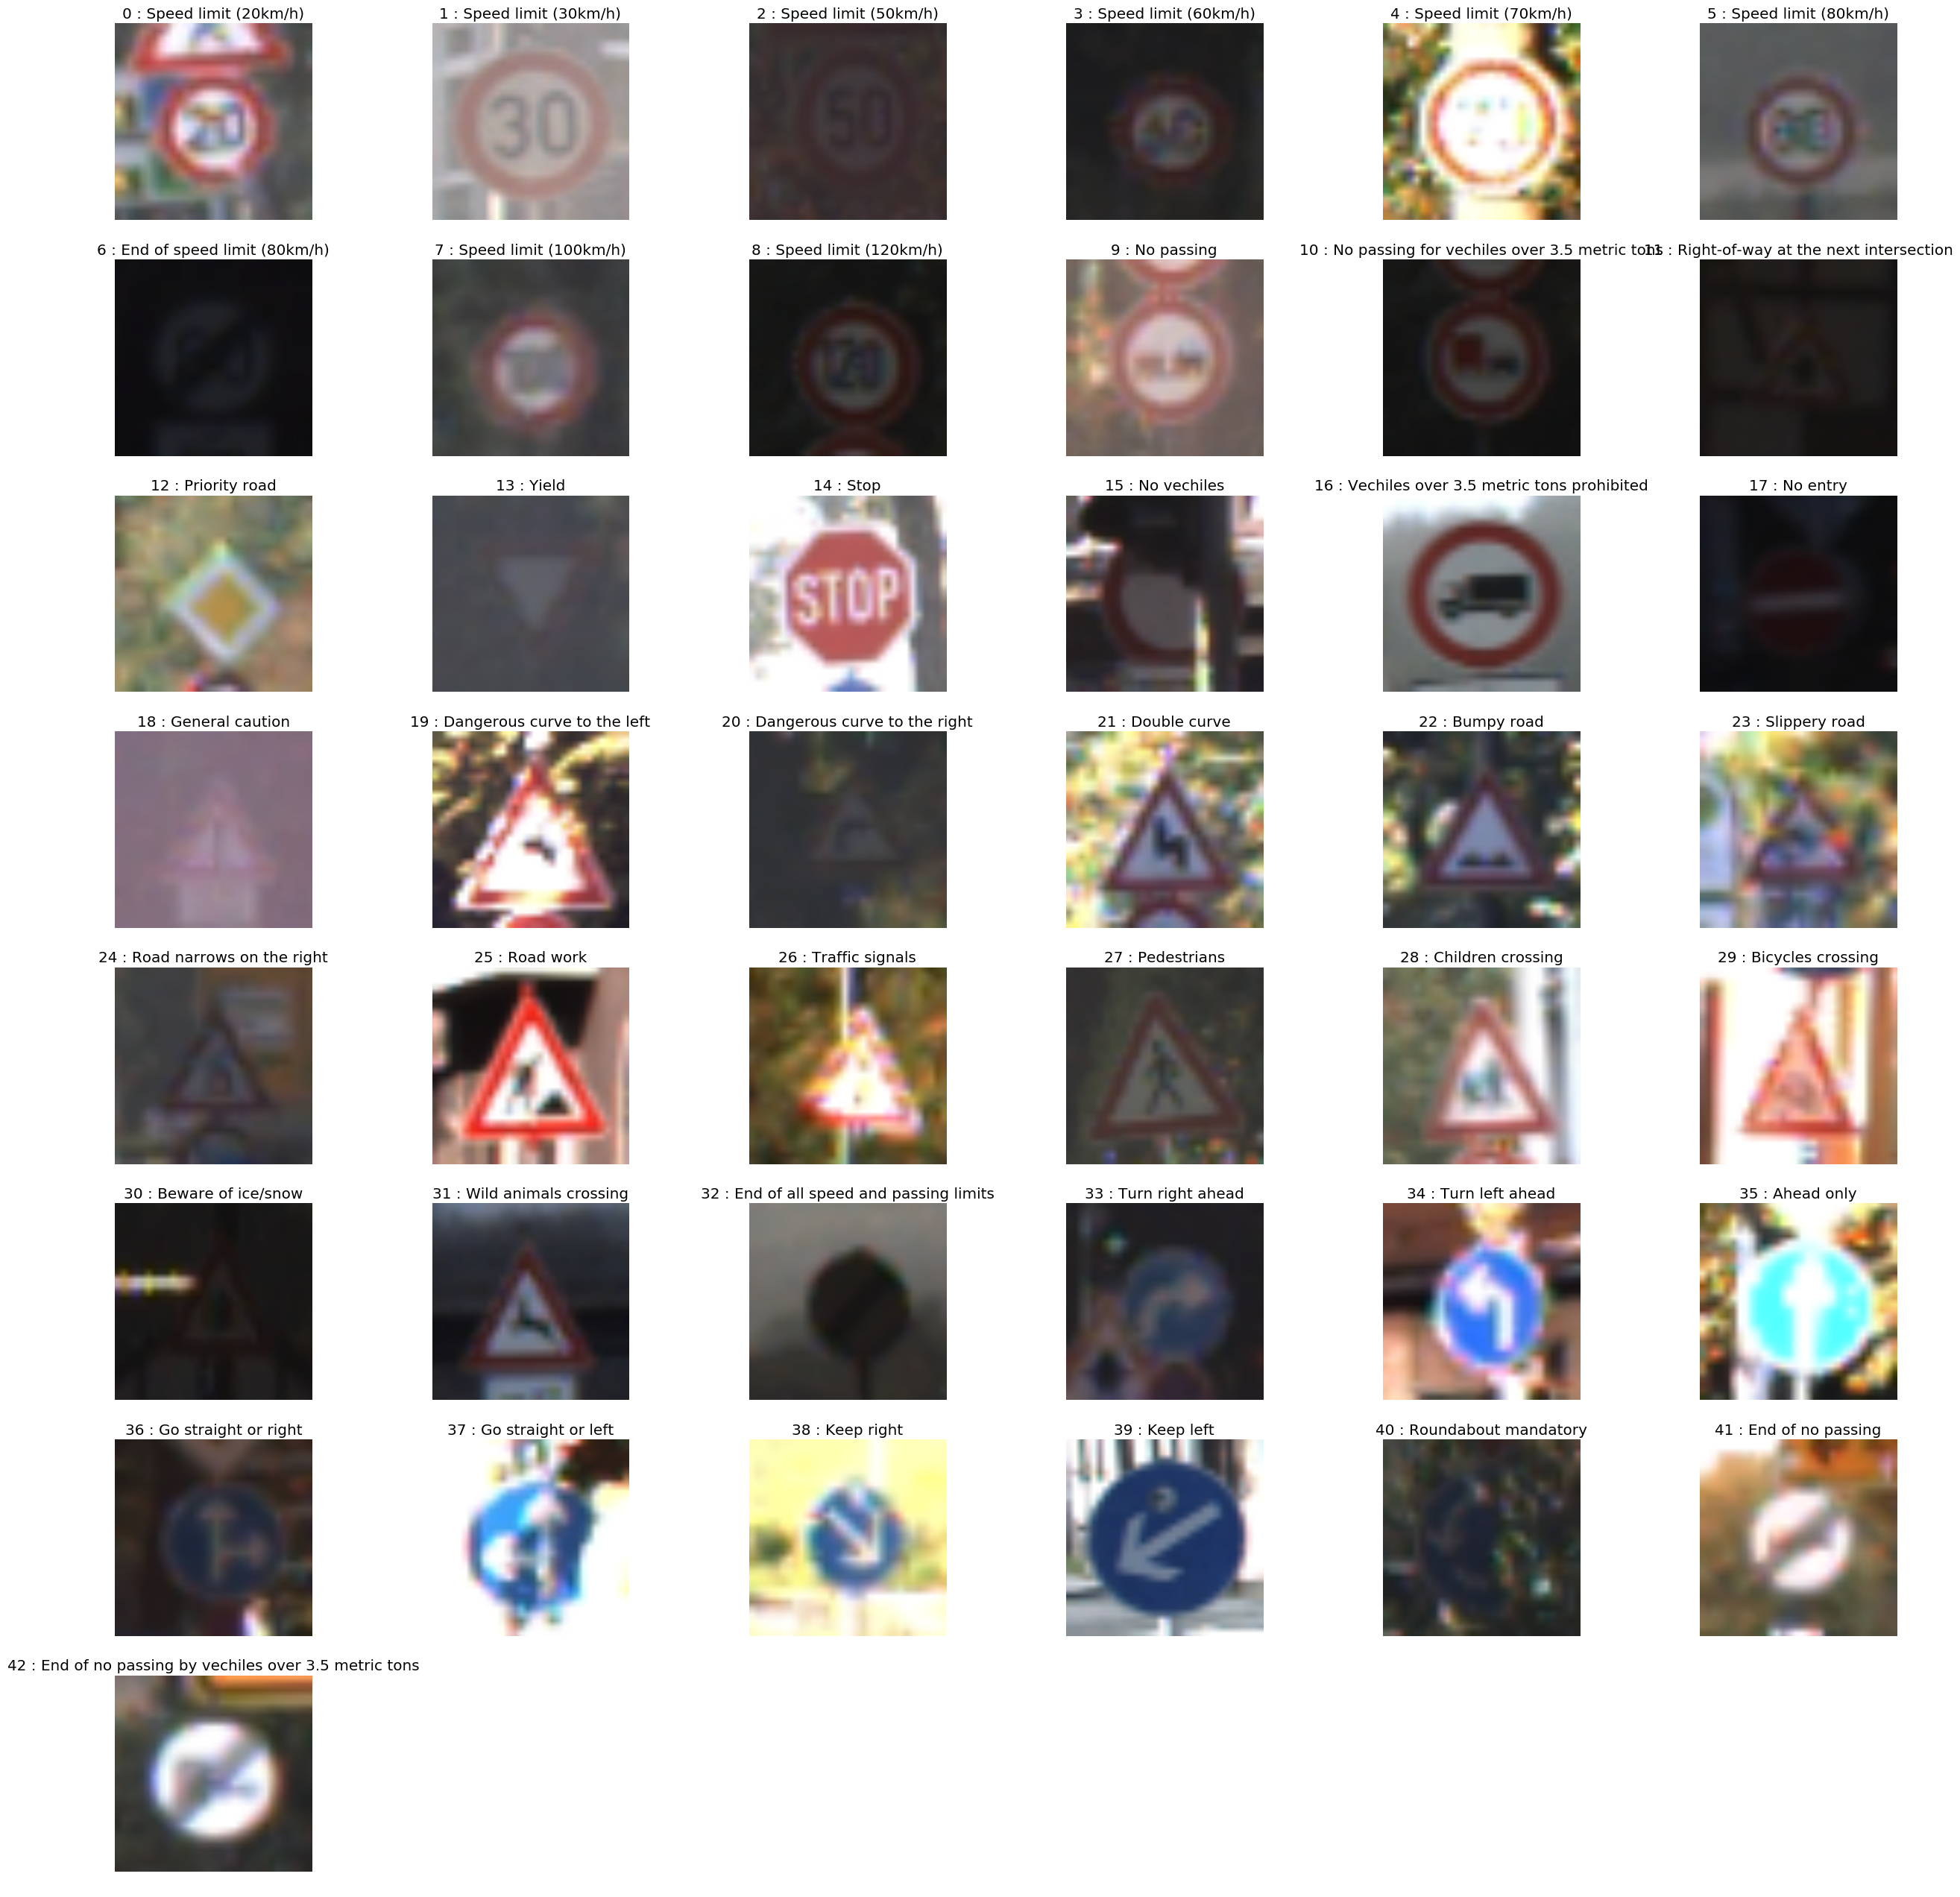

In [6]:
# Display a single image per label.
unique_label_images = {}
for image, label in zip(X_train, y_train):
    if not label in unique_label_images:
        unique_label_images[label] = image
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32, 32))
for key in unique_label_images.keys():
    plt.subplot(8, 6, key+1)
    plt.title("{1} : {0}".format(sign_names[key],key))
    plt.axis('off')
    var_holder = plt.imshow(unique_label_images[key])
plt.show()

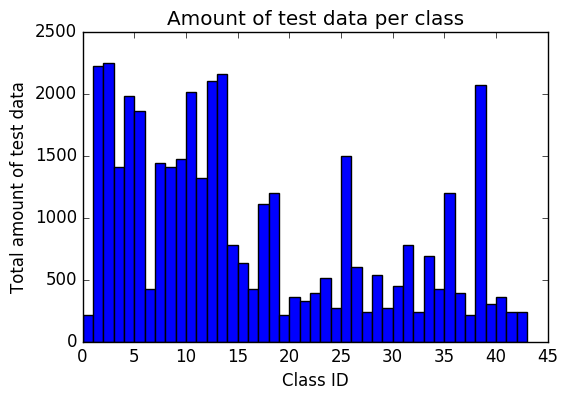

lowest amount of test data in a class: 210
highest amount of test data in a class: 2250


In [32]:
###Get amount of test cases per class
number_of_classes = {class_n:0 for class_n in set(y_train)}
for c in y_train:
    number_of_classes[c] += 1 
a = plt.bar(number_of_classes.keys(), number_of_classes.values(), width=1)
plt.title('Amount of test data per class')
plt.xlabel('Class ID')
plt.ylabel('Total amount of test data')
plt.show()
print('lowest amount of test data in a class: {0}'.format(min(number_of_classes.values())))
print('highest amount of test data in a class: {0}'.format(max(number_of_classes.values())))

In [8]:
##Percent of classes where the total test data is greater than 1000
sum(1 for val in number_of_classes.values() if val > 1000)/len(number_of_classes.values())

0.3953488372093023

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### set max amount of test data per class = 1000 to avoid Imbalanced Data
training_features = []
training_labels = []
n_features = {class_n:0 for class_n in set(y_train)}
for image, label in zip(X_train,y_train):
    if n_features[label] < 1000:
        training_features.append(image)
        training_labels.append(label)
        n_features[label] += 1

In [10]:
##Convert images from RGB to GRAYSCALE
import cv2
import numpy as np
gray_train_features = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  training_features]
gray_test_features = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  X_test]


In [11]:
## normalize the images using minmax normalization
def normalize_greyscale(image, a=0.1, b=0.9,grey_min=0,grey_max=255):
    return a + ( ( (image - grey_min)*(b - a) )/( grey_max - grey_min ) )
train_features = [normalize_greyscale(image) for image in gray_train_features]
test_features = [normalize_greyscale(image) for image in gray_test_features]

In [12]:
##Shuffle the data 
from sklearn.utils import shuffle
train_features, train_labels = shuffle(train_features,training_labels, random_state=0)

In [13]:
##One hot encode the labels
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(y_test)

In [14]:
# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [15]:
import tensorflow as tf

# Parameters
learning_rate = 0.01
training_epochs = 150
batch_size = 100
display_step = 10

n_input = 1024
n_classes = 43

n_hidden_layer = 1024



weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_classes]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

#Graph input
x = tf.placeholder("float", [None, 32, 32])
y = tf.placeholder("float", [None, n_classes])
x_flat = tf.reshape(x, [-1, n_input])


# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])
relu_layer = tf.nn.relu(layer_1)

# Output layer with linear activation
logits = tf.add(tf.matmul(relu_layer, weights['out']),biases['out'])

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

##Define top k variables
top_k = tf.placeholder(tf.int32)
top_k_val,top_k_ind = tf.nn.top_k(logits,k=top_k)

# save the model for later
saver = tf.train.Saver()

# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
# Initializing the variables
init = tf.initialize_all_variables()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

* Imbalanced data: 
    After seeing that the amount of test data isn't the same amount per class, I decided to combat this issue by having a max of 1000 test cases per class (since 60% of the classes had less than 1000 test cases). I didn't mix the test and training data because I was worried of over-fitting (as seen above there are many images from the same physical sign).
* Convert from RGB to grayscale - using opencv
* Normalize the data - using minmax normalization with a range of 0.1-0.9
* Shuffle the data - for better training performance
* One hot encode the labels -scikit learn



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The training and testing data were preprocessed and in separate files, Thanks to the amazing folks at Udacity.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is a simple neural network with 3 steps: 

**input => sofmax => relu => softmax => output **  
The input size is 1024 since the image is of dimension 32*32.  
The number of hidden layers is 1024 nodes (this was my second choice after trying 512 ) 

In [16]:
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_start = i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_features, y: batch_labels})
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print ("Iter:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")
    print("Accuracy on testing data:", accuracy.eval({x: test_features, y: test_labels}))
    print("Accuracy on training data:", accuracy.eval({x: train_features, y: train_labels}))
    save_path = saver.save(sess, "saved_models/model.ckpt")

Iter: 0010 cost= 2.164355341
Iter: 0020 cost= 0.720644225
Iter: 0030 cost= 0.539959702
Iter: 0040 cost= 0.481350349
Iter: 0050 cost= 0.389841424
Iter: 0060 cost= 0.354775959
Iter: 0070 cost= 0.314454908
Iter: 0080 cost= 0.293869545
Iter: 0090 cost= 0.295485797
Iter: 0100 cost= 0.236507031
Iter: 0110 cost= 0.268417633
Iter: 0120 cost= 0.254611040
Iter: 0130 cost= 0.260411941
Iter: 0140 cost= 0.204217203
Iter: 0150 cost= 0.288111312
Optimization Finished!
Accuracy on testing data: 0.726207
Accuracy on training data: 0.860395


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Adam Optimizer (as opposed to a simple gradient decent optimizer) since it gave me a better accuracy
* learning rate of 0.01 ( I tried 0.5,0.1,0.01,0.001 and this gave me the best accuracy)
* batch size of 100 (I tried 25,50,100,200 and this had the best accuracy)
* 150 iterations


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started off by creating a simple logistic regression which gave me an accuracy of 71% after 100 iterations.I then created a simple neural network which gave me an accuracy of 75% after 1000 iterations. I then created a simple multi level deep neural network which gave me an accuracy of 8% after 1000 iterations(see other files in this github repo).   
I decided to stick with the simple neural network and optimize it to get better performance.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

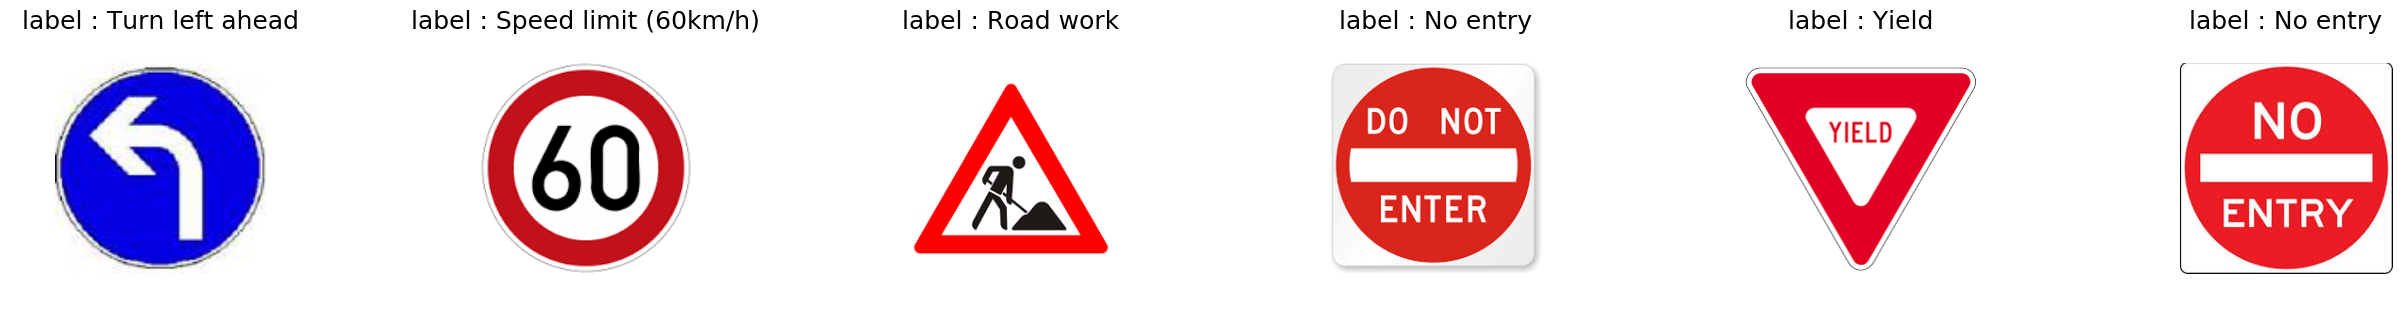

In [17]:
##Display the images
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
testing_images = []
for fname in glob.glob("testing_images/*"):
    if fname[fname.find('.'):] == '.png':
        image = (mpimg.imread(fname)*255).astype('uint8')
    else:
        image = mpimg.imread(fname )
    testing_images.append(image)

testing_labels = [34,3,25,17,13,17]## => these labels were created manualy based on the downloaded images

labels = [sign_names[lab] for lab in testing_labels]
plt.clf()
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(32,6))
i = 1
for image, label in zip(testing_images,labels):
    plt.subplot(2,6, i)
    plt.title("label : " + label + "\n ")
    plt.axis('off')
    var_holder = plt.imshow(image)
    i+=1
plt.show()


In [18]:
##Resize, greyscale and normalize the images
import cv2
resized_images = [cv2.resize(image, (32, 32)) for image in testing_images]
grey_scale = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in  resized_images]
normalized_images = [normalize_greyscale(image) for image in grey_scale]

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The images were downloaded from the internet ( see **Download testing images.ipynb** in this repo), I chose 2 'no entry with different wordings to see how well my model will perform on them, 1 turn left ahead, 1 yield and 1 working.

In [19]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    n_logits = logits.eval({x: normalized_images})
    

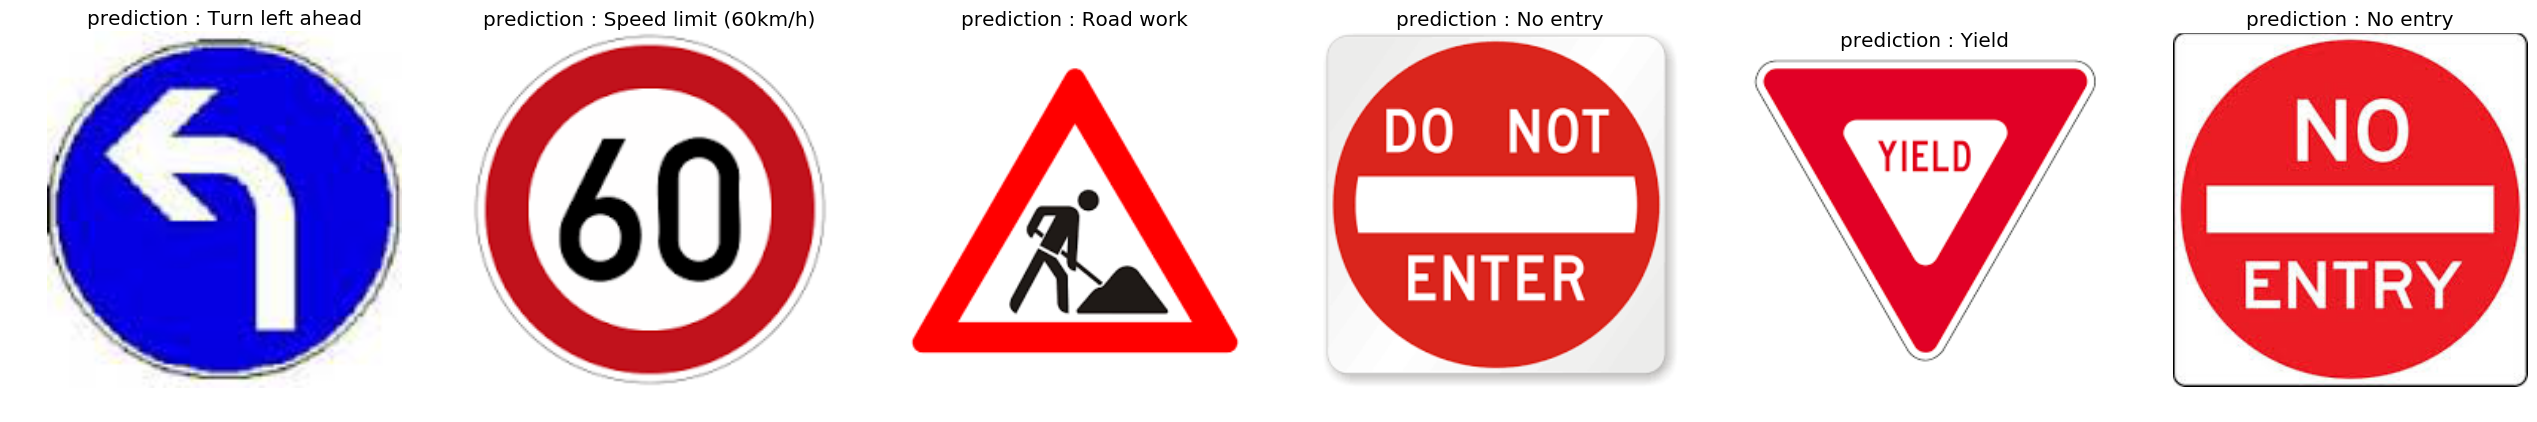

In [20]:
## get the highest predicted value and plot the predicted label on the image
import operator
labels = [sign_names[max(enumerate(logit), key=operator.itemgetter(1))[0]] for logit in n_logits]
plt.clf()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(32,12))
i = 1
for image, label in zip(testing_images,labels):
    plt.subplot(2,6, i)
    plt.title("prediction : " + label)
    plt.axis('off')
    var_holder = plt.imshow(image)
    i+=1
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [21]:
test_one_hot_labels = encoder.transform(testing_labels)
test_one_hot_labels = test_one_hot_labels.astype(np.float32)
saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    test_accuracy = accuracy.eval({x: normalized_images, y: test_one_hot_labels})
    print("Accuracy on the downloaded test images : " , test_accuracy)

Accuracy on the downloaded test images :  1.0


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


In [24]:
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "saved_models/model.ckpt")
    indices = top_k_ind.eval({x: normalized_images,top_k: 5})
    values = top_k_val.eval({x: normalized_images,top_k: 5})

In [25]:
##print all predictions for images that were wrongly labeled by the model
wrong_prodiction = False
for top_5,label in zip(indices,testing_labels):
    if label != top_5[0] and label in top_5:
        wrong_prodiction = True
        print("sign",sign_names[label], "was labeled as ",[sign_names[pred] for pred in top_5] )
    elif label not in top_5:
        wrong_prodiction = True
        print("sign",sign_names[label], "was not in the top 5 predictions")
if not wrong_prodiction:
    print("all images were correctly classified by the model")

all images were correctly classified by the model


In [31]:
## the higher the difference between the top predicted label and the second highest, 
## the more sure the model is about it's prediction.
for i in range(6):
    print("For sign", sign_names[testing_labels[i]],\
          ": the difference between the weight of the predicted label (",sign_names[indices[i][0]],") and a second label (",sign_names[indices[i][1]],") is ",\
          values[i][0] - values[i][1])
    

For sign Turn left ahead : the difference between the weight of the predicted label ( Turn left ahead ) and a second label ( Children crossing ) is  6.31297
For sign Speed limit (60km/h) : the difference between the weight of the predicted label ( Speed limit (60km/h) ) and a second label ( Speed limit (50km/h) ) is  15.5508
For sign Road work : the difference between the weight of the predicted label ( Road work ) and a second label ( Bicycles crossing ) is  80.8913
For sign No entry : the difference between the weight of the predicted label ( No entry ) and a second label ( Turn right ahead ) is  75.4138
For sign Yield : the difference between the weight of the predicted label ( Yield ) and a second label ( Ahead only ) is  200.773
For sign No entry : the difference between the weight of the predicted label ( No entry ) and a second label ( Turn left ahead ) is  168.011


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

I resized the images to be 32*32 and did the same preprocessing on the images as done in the training data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Conclusion:
This project gave me hands on experience creating a deep neural network using tensorflow.  
There were many knobs to turn when creating a neural network. Batch size, learning rate, different types of optimizers and amount of iterations can all be tweaked to get a better performing model.  
I really wish that I had a better computer to test them all any perhaps get a intuition which knob to turn when, but with my current computer (I am using a docker container on a windows 7 computer with no GPU), it is brutal to train multiple different models.  
My next step to optimize this project is to create a convolutional neural network and see how well it performs.
